In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import datetime


df = pd.read_csv("data/2022_place_canvas_history-000000000000.csv.gzip", compression="gzip")

df.head()

,timestamp,user_id,pixel_color,coordinate
0,2022-04-04 00:53:51.577 UTC,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...,#00CCC0,"826,1048"
1,2022-04-04 00:53:53.758 UTC,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...,#94B3FF,"583,1031"
2,2022-04-04 00:53:54.685 UTC,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...,#6A5CFF,"1873,558"
3,2022-04-04 00:54:57.541 UTC,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...,#009EAA,"1627,255"
4,2022-04-04 00:55:16.307 UTC,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...,#94B3FF,"49,1478"


In [8]:
def parse_date(date):
    try:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S.%f')
    except:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S')

df['timestamp'] = df['timestamp'].apply(lambda x: parse_date(x))

In [9]:
df['user_id'] = df['user_id'].astype('string')
df['pixel_color'] = df['pixel_color'].astype('string')
df["coordinate"] = df["coordinate"].apply(lambda x: float(x.replace(",", ".")) if isinstance(x, str) else float(x))

df.dtypes

timestamp      datetime64[ns]
user_id                string
pixel_color            string
coordinate            float64
dtype: object

In [10]:
colors = df["pixel_color"].value_counts().rename_axis('pixel_color').to_frame('counts').reset_index()
colors.head()

,pixel_color,counts
0,#000000,270396
1,#FFFFFF,205666
2,#2450A4,63860
3,#FF4500,63430
4,#BE0039,61356


<AxesSubplot:xlabel='pixel_color'>

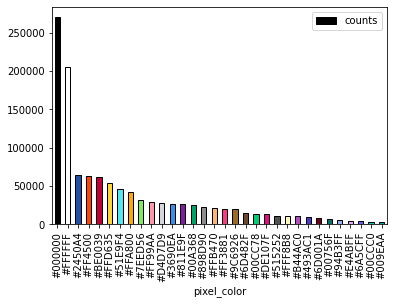

In [11]:
colors.plot.bar(x="pixel_color", y="counts", color=colors["pixel_color"], edgecolor="#000000")
